# Wyznaczanie diagramu Voronoi poprzez triangulację Delaunay'a

In [205]:
# import numpy as np
from bitalg.visualizer.main import Visualizer
from random import uniform
from math import sqrt

EPS = 1e-8

### Obiekty

##### Klasa punktu

In [206]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def distance(self, p):
        return sqrt((self.x - p.x)**2 + (self.y - p.y)**2)

##### Może się przydać

In [207]:
""" Może się przydać """
"""
    def __equals__(self, other):
        points_self = {self.p1, self.p2, self.p3}
        points_other = {other.p1, other.p2, other.p3}

        # Sprawdzenie, czy trójkąty mają takie same punkty wierzchołkowe z tolerancją EPS
        for point_self in points_self:
            found = False
            for point_other in points_other:
                if point_self.distance(point_other) < self.EPS:
                    found = True
                    break
            if not found:
                return False
"""

'\n    def __equals__(self, other):\n        points_self = {self.p1, self.p2, self.p3}\n        points_other = {other.p1, other.p2, other.p3}\n\n        # Sprawdzenie, czy trójkąty mają takie same punkty wierzchołkowe z tolerancją EPS\n        for point_self in points_self:\n            found = False\n            for point_other in points_other:\n                if point_self.distance(point_other) < self.EPS:\n                    found = True\n                    break\n            if not found:\n                return False\n'

##### Klasa trójkąta

In [208]:
def mat_det_3x3(p1, p2, p3):
    det = (p2.x - p1.x)*(p3.y - p2.y) - (p2.y - p1.y)*(p3.x - p2.x)
    if det > EPS: return 1
    elif det < -EPS: return -1
    else: return 0
    # return == -1 -> p3 po prawej stronie prostej (p1,p2)
    # return == -1 -> punkty zgodnie z ruchem wskazówek zegara

class Triangle:
    def __init__(self, p1, p2, p3):
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        self.o, self.R = self.set_circle()

    def __contains__(self, p):
        # Test if a point is in a triangle
        a12 = mat_det_3x3(self.p1, self.p2, self.p3)
        b12 = mat_det_3x3(self.p1, self.p2, p)
        a23 = mat_det_3x3(self.p2, self.p3, self.p1)
        b23 = mat_det_3x3(self.p2, self.p3, p)
        a31 = mat_det_3x3(self.p3, self.p1, self.p2)
        b31 = mat_det_3x3(self.p3, self.p1, p)
        return (a12 * b12 >= 0) and (a23 * b23 >= 0) and (a31 * b31 >= 0)

    def __eq__(self, other):
        if self is None or other is None:
            return False
        S_points = {self.p1, self.p2, self.p3}
        O_points = {other.p1, other.p2, other.p3}
        return S_points == O_points
    
    def __hash__(self):
        return hash((self.p1, self.p2, self.p3))
    
    def set_circle(self):
        s1 = self.p1.x**2 + self.p1.y**2
        s2 = self.p2.x**2 + self.p2.y**2
        s3 = self.p3.x**2 + self.p3.y**2
        x13 = self.p1.x - self.p3.x
        x32 = self.p3.x - self.p2.x
        x21 = self.p2.x - self.p1.x
        y12 = self.p1.y - self.p2.y
        y23 = self.p2.y - self.p3.y
        y31 = self.p3.y - self.p1.y
        f = 2*(self.p1.x*y23 + self.p2.x*y31 + self.p3.x*y12)
        # Środek okręgu opisanego na trójkącie ma środek:
        x0 = (s1*y23 + s2*y31 + s3*y12)/f
        y0 = (s1*x32 + s2*x13 + s3*x21)/f
        # Promień okręgu opisanego na trójkącie wynosi:
        R = sqrt((x21**2 + y12**2) * (x13**2 + y31**2) * (x32**2 + y23**2))/abs(f)
        return Point(x0, y0), R

    def in_circle(self, p):
        if self.o.distance(p) <= self.o.distance(self.p1) - EPS:
            return True
        else:
            return False
        
    # Sortuje punkty, aby były przeciwnie do ruchu wskzówek zegara, tak że p1 jest najniższym punktem (najbardziej po lewej)
    def sort_tri_vertexes(self):
        p1 = self.p1
        p2 = self.p2
        p3 = self.p3
        if mat_det_3x3(p1, p2, p3) < 0:
            p1, p2 = p2, p1
        while(p1.y > min(p2.y, p3.y) or (p1.y == min(p2.y, p3.y) and p1.y != p2.y)):
            p1, p2, p3 = p2, p3, p1
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
    
    def get_edges(self):
        edges = set()
        self.sort_tri_vertexes()
        edges.add((self.p1, self.p2))
        edges.add((self.p2, self.p3))
        edges.add((self.p3, self.p1))
        return edges

##### Klasa triangulacji

In [209]:
class Triangulation:
    def __init__(self, P):
        self.edges = {}
        # edges to słownik, gdzie kluczem są krawędzie, których punkty są w kolejności przeciwnej do ruchu wskazówek zegara w trójkącie
        self.triangles = set()
        # central_point -> start_tri
        self.map_vertexes, self.central_point, self.central_triangle = self.get_triangulation_start(P)
    
    def get_triangulation_start(self, P):
        low_left = Point(float('inf'), float('inf'))
        up_right = Point(float('-inf'), float('-inf'))
        for p in P:
            if p.x < low_left.x:
                low_left.x = p.x
            if p.x > up_right.x:
                up_right.x = p.x
            if p.y < low_left.y:
                low_left.y = p.y
            if p.y > up_right.y:
                up_right.y = p.y
        low_left.x += -1
        low_left.y += -1
        up_right.x += 1
        up_right.y += 1
        map_vertexes = [low_left, Point(up_right.x, low_left.y), up_right, Point(low_left.x, up_right.y)]
        central_point = Point((low_left.x + up_right.x)/2, (low_left.y + up_right.y)/2 + 1e-2)
        self.triangles.add(Triangle(low_left, Point(up_right.x, low_left.y), up_right))
        self.triangles.add(Triangle(low_left, up_right, Point(low_left.x, up_right.y)))
        central_triangle = None
        for tri in self.triangles:
            if central_point in tri:
                central_triangle = tri
            # already sorted
            self.edges[(tri.p1, tri.p2)] = tri.p3
            self.edges[(tri.p2, tri.p3)] = tri.p1
            self.edges[(tri.p3, tri.p1)] = tri.p2
        return map_vertexes, central_point, central_triangle

    def find_adjacent_tri(self, edge):
        if (edge[1], edge[0]) in self.edges:
            tri = Triangle(edge[1], edge[0], self.edges[(edge[1], edge[0])])
            tri.sort_tri_vertexes()
            return tri
        return None
    
    def find_all_adjacent_tri(self, triangle):
        tri_adjacent = set()
        tri = self.find_adjacent_tri((triangle.p1, triangle.p2))
        if tri:
            tri_adjacent.add(tri)
        tri = self.find_adjacent_tri((triangle.p2, triangle.p3))
        if tri:
            tri_adjacent.add(tri)
        tri = self.find_adjacent_tri((triangle.p3, triangle.p1))
        if tri:
            tri_adjacent.add(tri)
        return tri_adjacent
    
    def remove(self, triangle):
        triangle.sort_tri_vertexes()
        if (triangle.p1, triangle.p2) in self.edges: del self.edges[(triangle.p1, triangle.p2)]
        if (triangle.p2, triangle.p3) in self.edges: del self.edges[(triangle.p2, triangle.p3)]
        if (triangle.p3, triangle.p1) in self.edges: del self.edges[(triangle.p3, triangle.p1)]
        self.triangles.remove(triangle)

    def add(self, triangle):
        triangle.sort_tri_vertexes()
        self.edges[(triangle.p1, triangle.p2)] = triangle.p3
        self.edges[(triangle.p2, triangle.p3)] = triangle.p1
        self.edges[(triangle.p3, triangle.p1)] = triangle.p2
        self.triangles.add(triangle)
        
    
    def adjust_triangulation(self, tri_to_remove, p):
        for tri in tri_to_remove:
            tri.sort_tri_vertexes()
        outer_edges = set()

        for tri in tri_to_remove:
            tri_edges = tri.get_edges() # set krawędzi trójkąta
            for edge in tri_edges:
                if not ((edge[1], edge[0]) in self.edges):
                    outer_edges.add(edge)
                elif not (self.find_adjacent_tri(edge) in tri_to_remove):
                    outer_edges.add(edge)

        for tri in tri_to_remove:
            self.remove(tri)

        added_tri = []
        for edge in outer_edges:
            tri = Triangle(edge[0], edge[1], p)
            tri.sort_tri_vertexes()
            added_tri.append(tri)
            self.add(tri)
        
        if self.central_triangle in tri_to_remove:
            for tri in added_tri:
                if self.central_point in tri:
                    self.central_triangle = tri


    def remove_map_vertexes(self):
        pass


### Funkcje pomocnicze funkcji delauney

In [210]:
def get_points(Points):
    P = []
    for point in Points:
        P.append(Point(point[0], point[1]))
    return P

def find_containing(T, p):
    curr_tri = T.central_triangle
    tri_visited = set()
    while True:
        tri_visited.add(curr_tri)
        p1 = curr_tri.p1
        p2 = curr_tri.p2
        p3 = curr_tri.p3
        if mat_det_3x3(p1, p2, p) < 0:
            curr_tri = T.find_adjacent_tri((p1, p2))
        elif mat_det_3x3(p2, p3, p) < 0:
            curr_tri = T.find_adjacent_tri((p2, p3))
        elif mat_det_3x3(p3, p1, p) < 0:
            curr_tri = T.find_adjacent_tri((p3, p1))
        else:
            return curr_tri

### Główna funkcja delauney

In [211]:
def delauney(Points):
    P = get_points(Points)
    T = Triangulation(P)

    for p in P:
        containing_tri = find_containing(T, p)
        tri_to_remove = [] # trójkąty do usunięcia
        tri_visited = [] # odwiedzone trójkąty
        stack = [containing_tri]

        while len(stack) > 0:
            curr_tri = stack.pop()
            tri_visited.append(curr_tri)

            if curr_tri.in_circle(p):
                tri_to_remove.append(curr_tri)
                tri_adjacent = T.find_all_adjacent_tri(curr_tri) # trójkąty sąsiadujące z curr_tri

                for triangle in tri_adjacent:
                    if triangle not in tri_visited and triangle not in stack:
                        stack.append(triangle)
            
        T.adjust_triangulation(tri_to_remove, p)
    
    T.remove_map_vertexes()
    return T

### Dane testowe - delauney

In [223]:
def generate_uniform_points(left, right, n=20):
    Points = [None for _ in range(n)]
    for i in range(n):
        xi = uniform(left, right)
        yi = uniform(left, right)
        Points[i] = (xi, yi)
    return Points

In [229]:
Points1 = [(0,7), (2,1), (7,6)]
T1 = delauney(Points1)

Points2 = [(0,7), (2,1), (7,6), (2,4), (8.45,-2), (0,0)]
T2 = delauney(Points2)

Points3 = generate_uniform_points(-10, 10, n=50)
T3 = delauney(Points3)

In [230]:
def draw_delauney(T, Points):
    vis = Visualizer()
    vis.add_point(Points, color='red')
    for edge in T.edges:
        line_segment = ((edge[0].x, edge[0].y), (edge[1].x, edge[1].y))
        vis.add_line_segment(line_segment)
    vis.axis_equal()
    return vis

### Testy - delauney

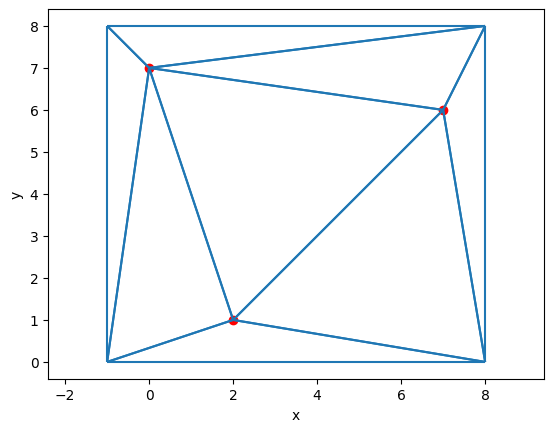

In [231]:
vis1 = draw_delauney(T1, Points1)
vis1.show()

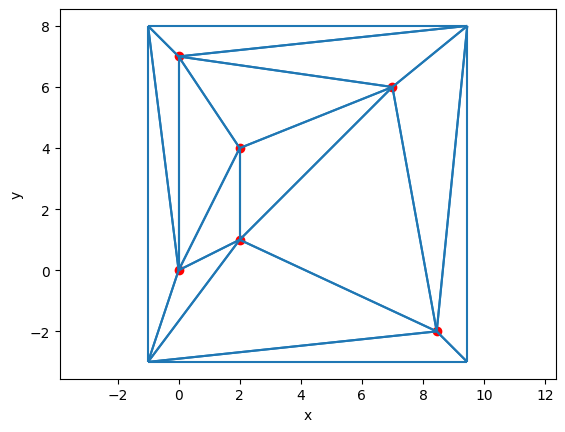

In [232]:
vis2 = draw_delauney(T2, Points2)
vis2.show()

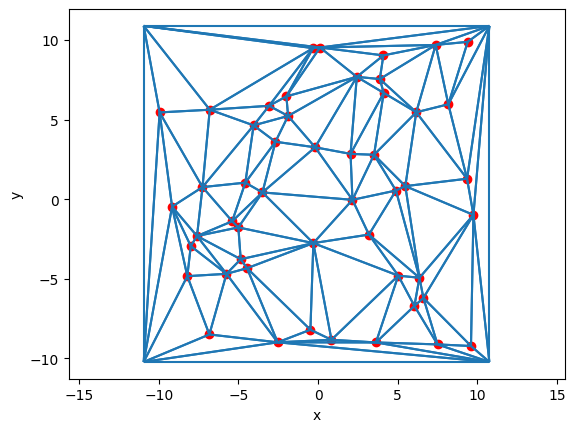

In [233]:
vis3 = draw_delauney(T3, Points3)
vis3.show()